In [1]:
import torchvision
from torchvision.models import resnet50
from torchvision import transforms as T
import torch
from torch.nn.utils import clip_grad_norm_
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer
import pandas as pd
from PIL import Image
import random
from torchmetrics import BLEUScore
from tqdm import tqdm
from torchtext.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence
import PIL
from torchvision.transforms import v2
from torchvision import models
from torcheval.metrics.functional import bleu_score

In [2]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
    model.train()
    loss_train = AverageMeter()
    with tqdm(train_loader, unit='batch') as tepochs:
        for img, captions in tepochs:
            if epoch is not None:
                tepochs.set_description(f'epoch:{epoch}')
            yp, alphas = model(img.to(device), captions.to(device))
            loss = loss_fn(yp.transpose(2, 1), captions.to(device)[:, 1:])
            loss += 1. * ((1. - alphas.sum(dim=1)) ** 2).mean() 
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            tepochs.set_postfix(loss=loss_train.avg)
            loss_train.update(loss.item())
    return model, loss_train.avg

def evaluate(model, test_loader, loss_fn):
    model.eval()
    loss_test = AverageMeter()
    with torch.no_grad():
        for img, captions, flr in test_loader:
            yp, alphas = model(img.to(device), captions.to(device))
            loss = loss_fn(yp.transpose(2, 1), captions.to(device)[:, 1:])
            loss += 1. * ((1. - alphas.sum(dim=1)) ** 2).mean()
            loss_test.update(loss.item())
    print(loss_test.avg)
    return loss_test.avg

def generate(img):
    with torch.no_grad():
        model.eval()
        generated = [vocab['<sos>']]
        for i in range(15):
            preds, _ = model(
                img.unsqueeze(0).to(device), torch.LongTensor(generated).unsqueeze(0).to(device), generate=True)
            argm = preds.argmax(-1)[:, -1]
            generated.append(argm)
            if argm == vocab['<eos>']:
                break
    generated = ' '.join([index2char[c] for c in generated if c != vocab['<sos>'] and c != vocab['<eos>']])
    return generated


def calculate_bleu(dataloader, n_gram, many):
    bleu = BLEUScore(n_gram=n_gram)
    for images, _, captions in dataloader:
        images = images.to(device)
        generated_caption = list()
        # Generate caption using the model
        for i in range(0, many):
            generated_caption.append(generate(images[i]))

        candidates = generated_caption
        references = captions[:many]
        bleu.update(candidates, references)

    return bleu.compute()



class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [3]:
embed_size = 500
rnn_unit = 650
att_dim = 650
bs = 50
dropout_l = 0.5
dropout_h = 0.5
dropoute = 0.5
encoded_dropout = 0.5
specials = ['<pad>', '<sos>', '<eos>', '<unk>']
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [4]:
train_transform = v2.Compose([
                            v2.ToTensor(),
                            v2.RandAugment(),
                            v2.ToTensor(),
                            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
transofrm = v2.Compose([
    v2.ToTensor(),  # Convert the image to a tensor
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


/home/vahid/anaconda3/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [5]:
data = pd.read_csv('Flickr8k_text/Flickr8k.token.txt', sep='\t', names=['path', 'caption'])
with open('Flickr8k_text/Flickr_8k.trainImages.txt') as td :
    train = td.read().splitlines()
with open('Flickr8k_text/Flickr_8k.devImages.txt') as td :
    valid = td.read().splitlines()
with open('Flickr8k_text/Flickr_8k.testImages.txt') as tt :
    test = tt.read().splitlines()
test_data = list()
train_data = list()
valid_data = list()
for i, row in data.iterrows():
    if row['path'][:-2] in train:
        train_data.append([row['path'][:-2], row['caption'].lower()])
    if row['path'][:-2] in valid:
        valid_data.append([row['path'][:-2], row['caption'].lower()])
    if row['path'][:-2] in test:
        test_data.append([row['path'][:-2], row['caption'].lower()])
train_data = pd.DataFrame(train_data, columns=['path', 'caption'])
valid_data = pd.DataFrame(valid_data, columns=['path', 'caption'])
test_data = pd.DataFrame(test_data, columns=['path', 'caption'])

In [6]:
tokenizer = get_tokenizer('basic_english')
vocab = build_vocab_from_iterator(
    [tokenizer(i.lower()) for i in list(train_data['caption'])],
                                  special_first=True, specials=specials)
vocab.set_default_index(vocab['<unk>'])
index2char = vocab.get_itos()

In [7]:
# create a dictionary which every_

class FKSET(Dataset):
    def __init__(self, data, transform_x, phase='train'):
        self.phase = phase
        self.images = dict()
        self.labels = list()
        self.labex = dict()
        self.transform = transform_x

        for i in range(0, len(data), 5):
            self.labex[i] = [a.lower() for a in data['caption'].iloc[i:i+5]]
            self.labels.extend([[[vocab[c] for c in tokenizer('<sos> '+b +' <eos>')],i] 
                                for b in data['caption'].iloc[i:i+5]])
            if phase == 'valid':
                self.images[i] = self.transform(Image.open('data/' + data['path'].iloc[i]).resize([224, 224]))
            else :
                self.images[i] = Image.open('data/' + data['path'].iloc[i]).resize([256, 256])

    def __getitem__(self, idx):
        if self.phase != 'train':        
            random_choice = random.randint(0, 4)
            item = self.labels[idx]
            label = item[0]
            labels = self.labex[item[1]]
            image = self.images[item[1]]
            return image, torch.LongTensor(label), labels
        item = self.labels[idx]
        label = item[0]
        image = self.images[item[1]]
        return self.transform(image), torch.LongTensor(label)
    
    def __len__(self):
        return len(self.labels)

In [8]:
train_set = FKSET(train_data, train_transform)
test_set = FKSET(test_data, transofrm, phase='test')
valid_set = FKSET(valid_data, transofrm, phase='valid')

In [9]:
def collate(batch):
    images = torch.stack([b[0] for b in batch])
    vecs = [b[1] for b in batch]
    captions = pad_sequence(vecs, batch_first=True, padding_value=vocab['<pad>'])
    return images, captions

def collate_valid(batch):
    images = torch.stack([b[0] for b in batch])
    vecs = [b[1] for b in batch]
    captions_fulls = [b[2] for b in batch]
    captions = pad_sequence(vecs, batch_first=True, padding_value=vocab['<pad>'])
    return images, captions, captions_fulls

def collate_test(batch):
    images = [b[0] for b in batch]
    vecs = [b[1] for b in batch]
    captions_fulls = [b[2] for b in batch]
    captions = pad_sequence(vecs, batch_first=True, padding_value=vocab['<pad>'])
    return images, captions, captions_fulls


In [10]:
train_loader = DataLoader(train_set, bs, True, collate_fn=collate, num_workers=2)
test_loader = DataLoader(test_set, bs, True, collate_fn=collate_test)
valid_loader = DataLoader(valid_set, bs, True, collate_fn=collate_valid)

In [11]:
class CNNEncoder(nn.Module):
    def __init__(self, encoded_image_size=14, attention_method='bychannel', encoder_dim=512):
        super().__init__()
        self.attention_method = attention_method
        res = models.resnet101(weights=models.ResNet101_Weights.IMAGENET1K_V2)
        modules = list(res.children())[:-2]
        self.encoder = nn.Sequential(*modules)
        if self.attention_method == "bychannel":
            self.cnn1 = nn.Conv2d(in_channels=2048, out_channels=encoder_dim, kernel_size=(1, 1), stride=(1, 1), bias=False)
            self.bn1 = nn.BatchNorm2d(encoder_dim, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            self.relu = nn.ReLU(inplace=True)
        self.adaptive_pool = nn.AdaptiveAvgPool2d(encoded_image_size)
        self.encoder.requires_grad_(False)
        self.dropout = nn.Dropout()
    def forward(self, x):
        out = self.encoder(x) # 2048 output
        if self.attention_method == "bychannel":  # [batch_size, 2048, 8, 8] -> # [batch_size, 512, 8, 8]
            out = self.dropout(self.relu(self.bn1(self.cnn1(out))))
        out = self.dropout(self.adaptive_pool(out)) # going to bs > if by channel 512 else 2048, encoded size, encoded size
        out = out.permute(0, 2, 3, 1) # going to bs > encoded size, encoded size > num_channels
        return out

In [12]:
class Attention(nn.Module):
    def __init__(self, rnn_unit, encoder_dim, attention_unit):
        super().__init__()
        self.decoder = nn.Linear(rnn_unit, attention_unit)
        self.encoder = nn.Linear(encoder_dim, att_dim)
        self.full_attention = nn.Linear(attention_unit, 1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, encoder, hiddens):
        attention_1 = self.decoder(hiddens) # bs, att_dim
        attention_2 = self.encoder(encoder) # bs, np, att_dim
        scalar = self.full_attention(self.relu(attention_1.unsqueeze(1) + attention_2)).squeeze() # bs, np
        alpha = self.softmax(scalar) # bs, np, going to be bs summed of np and encoder_dim
        try :
            attention_weight = (encoder * alpha.unsqueeze(2)).sum(dim=1) # bs, encoder_dim
        except:
            attention_weight = (encoder * alpha.unsqueeze(1)).sum(dim=1) # bs, encoder_dim

        return attention_weight, alpha

In [13]:
class MxAttention(nn.Module): # attention which requires another attention
    def __init__(self, rnn_unit, encoder_dim, attention_unit):
        super().__init__()
        self.decoder = nn.Linear(rnn_unit, attention_unit)
        self.encoder = nn.Linear(encoder_dim, att_dim)
        self.ma = nn.Linear(encoder_dim, attention_unit)
        self.full_attention = nn.Linear(attention_unit, 1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, encoder, hiddens, attention_weights):
        attention_1 = self.decoder(hiddens) # bs, att_dim
        attention_2 = self.encoder(encoder) # bs, np, att_dim
        attention_3 = self.ma(attention_weights) # bs att dim

        scalar = self.full_attention(self.relu(attention_1.unsqueeze(1) + attention_3.unsqueeze(1)) + attention_2).squeeze() # bs, np
        alpha = self.softmax(scalar) # bs, np, going to be bs summed of np and encoder_dim
        try :
            attention_weight = (encoder * alpha.unsqueeze(2)).sum(dim=1) # bs, encoder_dim
        except:
            attention_weight = (encoder * alpha.unsqueeze(1)).sum(dim=1) # bs, encoder_dim

        return attention_weight, alpha

In [14]:
class LSTMAttention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, encoder_dim, rnn_unit, attention_unit):
        super().__init__()
        self.dropoute = nn.Dropout(dropoute)
        self.dropouth = nn.Dropout(dropout_h)
        self.dropoutl = nn.Dropout(dropout_l)
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=vocab['<pad>'])
        
        
        #block 1
        self.attention = Attention(rnn_unit, encoder_dim, attention_unit)
        self.decode_layer = nn.LSTMCell(embedding_dim+encoder_dim, rnn_unit) # lstm cell that create a layer
        self.f_beta = nn.Linear(rnn_unit, encoder_dim) #  create new gate 
        self.lm_s = nn.LSTMCell(rnn_unit+encoder_dim, rnn_unit)
        
        
        # block two using sniption
        self.snipetion = MxAttention(rnn_unit, encoder_dim, attention_unit)
        self.lm_snipe = nn.LSTMCell(rnn_unit+encoder_dim, rnn_unit)
        self.f_beta_n = nn.Linear(rnn_unit, encoder_dim)
        self.lm_ss = nn.LSTMCell(rnn_unit, rnn_unit)
        
        self.init_h = nn.Linear(encoder_dim, rnn_unit)
        self.init_c = nn.Linear(encoder_dim, rnn_unit)
        
        
        self.sigmoid = nn.Sigmoid() # sigmoid 
        self.fc = nn.Linear(rnn_unit, vocab_size) # decode high value features into vocab size
    
    def __init_hiddens(self, encoder):
        encoder = encoder.mean(dim=1)
        h = self.init_h(encoder)
        c = self.init_c(encoder)
        return h, c
    
    def forward(self, encoder_out, captions, generate=False):
        bs = encoder_out.size(0)
        encoder_out = encoder_out.view(bs, -1, encoder_out.size(-1)) # bs, pixels, channels
        
        num_p = encoder_out.size(1)
        
        embedding = self.dropoute(self.embedding(captions)) # bs, seq, embed size

        h, c = self.__init_hiddens(encoder_out) # init bs, encoder sized hiddens
        h_s, c_s = self.__init_hiddens(encoder_out)
        h_t, c_t = self.__init_hiddens(encoder_out)
        h_f, c_f = self.__init_hiddens(encoder_out)
        predictions = list()
        seq_len = captions.shape[1]-1 if not generate else captions.shape[1]
        alphas = torch.zeros(bs, seq_len, num_p).to(device)

        for sequence in range(seq_len):
            # block 1
            attention_weights, alpha = self.attention(encoder_out, h)
            gate = self.sigmoid(self.dropoutl(self.f_beta(h))) #bs , encoder_dim 
            attention_weights = gate * self.dropoutl(attention_weights)
            
            h, c = self.decode_layer(
            torch.cat([embedding[:, sequence, :], attention_weights], dim=1), (h, c))
            # second layer     
            h_s, c_s = self.lm_s(torch.cat([
               self.dropouth(h), attention_weights], dim=1), (h_s, c_s))
            # block two
            attention_weights, alpha = self.snipetion(encoder_out, h_s, attention_weights) # new weight that use super focus
            attention_weights = self.dropoutl(attention_weights)

            h_t, c_t = self.lm_snipe(torch.cat([
                                                self.dropouth(h_s), attention_weights], dim=1), (h_t, c_t))
            
            
            h_f, c_f = self.lm_ss(self.dropouth(h_t), (h_f, c_f))

            
            preds = self.fc(self.dropouth(h_f))
            predictions.append(preds)
            alphas[:, sequence, :] = alpha

        predictions = torch.stack(predictions, dim=1)
        return predictions, alphas

In [15]:
class ImageCap(nn.Module):
    
    def __init__(self, embedding_dim, rnn_unit, vocab_size, encoder_dim, attention_unit):
        
        super().__init__()
        self.encoder = CNNEncoder(encoder_dim=encoder_dim)
        self.decoder = LSTMAttention(vocab_size, embedding_dim, encoder_dim, rnn_unit, attention_unit)
    
    def forward(self, images, captions, generate=False):
        encoder_out = self.encoder(images)
        y, alphas = self.decoder(encoder_out, captions, generate=generate)
        return y, alphas

In [16]:
model = ImageCap(embed_size, rnn_unit, len(vocab), 1024, att_dim).to(device)

In [17]:
loss_train_hist = list()
loss_valid_hist = list()
pre_train_hist = list()
pre_valid_hist = list()
b_valid_hist = list()
best_loss_valid = torch.inf
epoch_counter = 0

In [18]:
loss_fn = nn.CrossEntropyLoss(ignore_index=vocab['<pad>'])

In [19]:
optimizer = optim.Adam(model.parameters(), weight_decay=1e-4)

In [20]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

37614302

In [21]:
n = 100
for epoch in range(n):
    model, train_loss = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)
#     if epoch != 0 and epoch % 5 == 0:
    valid_loss = evaluate(model, valid_loader, loss_fn)
    
    
    loss_train_hist.append(train_loss)
    loss_valid_hist.append(valid_loss)

    if valid_loss < best_loss_valid:
        torch.save(model,'modelx1.pt')
        best_loss_valid =  valid_loss
        print('Model SAVED') 

    epoch_counter +=1

epoch:0: 100%|████████████████████████████████████████████████████████████████| 600/600 [03:23<00:00,  2.95batch/s, loss=4.95]


4.237208604812622
Model SAVED


epoch:1: 100%|████████████████████████████████████████████████████████████████| 600/600 [03:23<00:00,  2.95batch/s, loss=4.14]


3.991007137298584
Model SAVED


epoch:2: 100%|████████████████████████████████████████████████████████████████| 600/600 [03:19<00:00,  3.01batch/s, loss=3.94]


3.862571380138397
Model SAVED


epoch:3: 100%|████████████████████████████████████████████████████████████████| 600/600 [03:20<00:00,  2.99batch/s, loss=3.81]


3.796760537624359
Model SAVED


epoch:4: 100%|████████████████████████████████████████████████████████████████| 600/600 [03:18<00:00,  3.02batch/s, loss=3.72]


3.7377076864242555
Model SAVED


epoch:5: 100%|████████████████████████████████████████████████████████████████| 600/600 [03:16<00:00,  3.05batch/s, loss=3.66]


3.6966988325119017
Model SAVED


epoch:6: 100%|████████████████████████████████████████████████████████████████| 600/600 [03:19<00:00,  3.01batch/s, loss=3.61]


3.6760937094688417
Model SAVED


epoch:7: 100%|████████████████████████████████████████████████████████████████| 600/600 [03:20<00:00,  2.99batch/s, loss=3.57]


3.6441185450553895
Model SAVED


epoch:8: 100%|████████████████████████████████████████████████████████████████| 600/600 [03:21<00:00,  2.98batch/s, loss=3.54]


3.638418962955475
Model SAVED


epoch:9: 100%|████████████████████████████████████████████████████████████████| 600/600 [03:19<00:00,  3.01batch/s, loss=3.51]


3.625262155532837
Model SAVED


epoch:10: 100%|███████████████████████████████████████████████████████████████| 600/600 [03:20<00:00,  2.99batch/s, loss=3.49]


3.6131632494926453
Model SAVED


epoch:11: 100%|███████████████████████████████████████████████████████████████| 600/600 [03:19<00:00,  3.01batch/s, loss=3.47]


3.605966024398804
Model SAVED


epoch:12: 100%|███████████████████████████████████████████████████████████████| 600/600 [03:20<00:00,  2.99batch/s, loss=3.46]


3.593889684677124
Model SAVED


epoch:13: 100%|███████████████████████████████████████████████████████████████| 600/600 [03:20<00:00,  3.00batch/s, loss=3.45]


3.590070126056671
Model SAVED


epoch:14: 100%|███████████████████████████████████████████████████████████████| 600/600 [03:20<00:00,  3.00batch/s, loss=3.43]


3.578074822425842
Model SAVED


epoch:15: 100%|███████████████████████████████████████████████████████████████| 600/600 [03:18<00:00,  3.02batch/s, loss=3.42]


3.5788890075683595


epoch:16: 100%|███████████████████████████████████████████████████████████████| 600/600 [03:18<00:00,  3.02batch/s, loss=3.41]


3.584023835659027


epoch:17:  28%|█████████████████▋                                             | 168/600 [00:56<02:25,  2.97batch/s, loss=3.36]


KeyboardInterrupt: 

In [28]:
b4 = calculate_bleu(valid_loader, 4, 3)
b1 = calculate_bleu(valid_loader, 1, 3)
b2 = calculate_bleu(valid_loader, 2, 3)
b3 = calculate_bleu(valid_loader, 3, 3)

/home/vahid/anaconda3/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `BLEUScore` from `torchmetrics` was deprecated and will be removed in 2.0. Import `BLEUScore` from `torchmetrics.text` instead.
  _future_warning(


In [29]:
print(f' n_gram 1: {b1:.4}\n n_gram 2: {b2:.4}\n n_gram 3: {b3:.4}\n n_gram 4: {b4:.4}')

 n_gram 1: 0.6435
 n_gram 2: 0.4302
 n_gram 3: 0.2941
 n_gram 4: 0.2042


In [ ]:
plt.plot(loss_train_hist, label='train')

plt.plot(loss_valid_hist, label='valid')
plt.legend()
plt.grid(True)

In [ ]:
plt.plot(b_valid_hist, label='bleu')
plt.legend()
plt.grid(True)

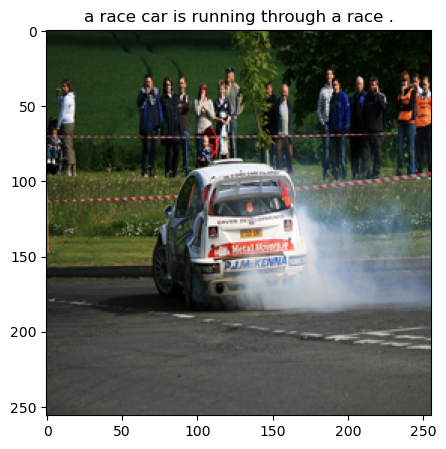

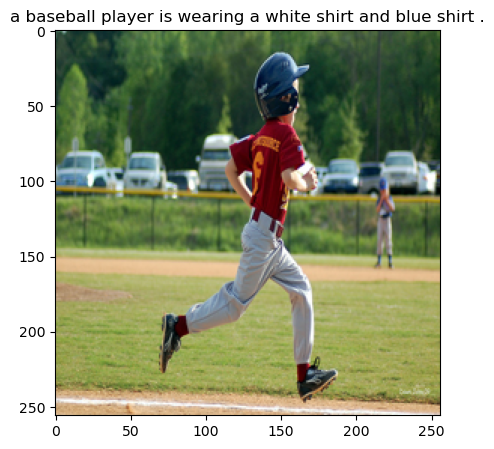

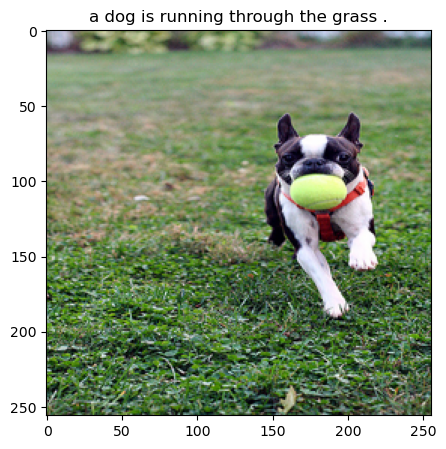

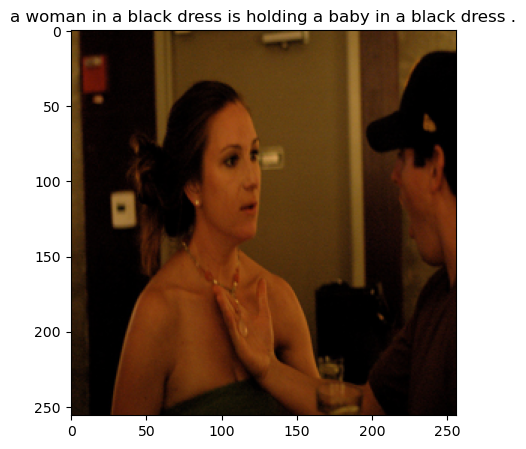

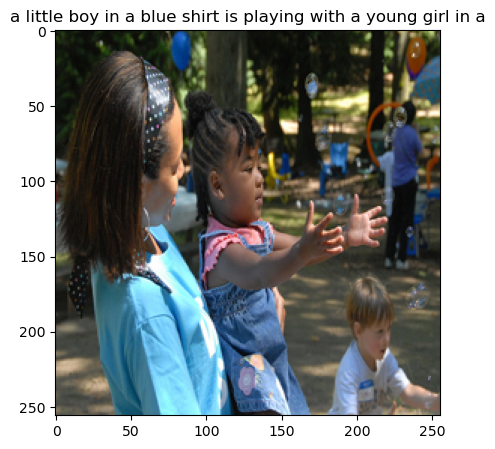

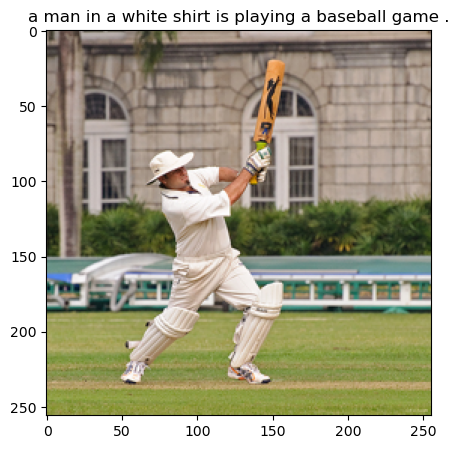

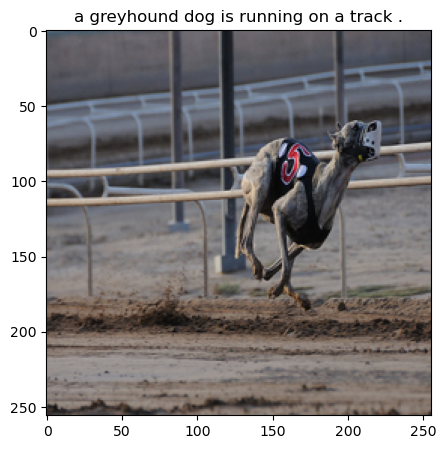

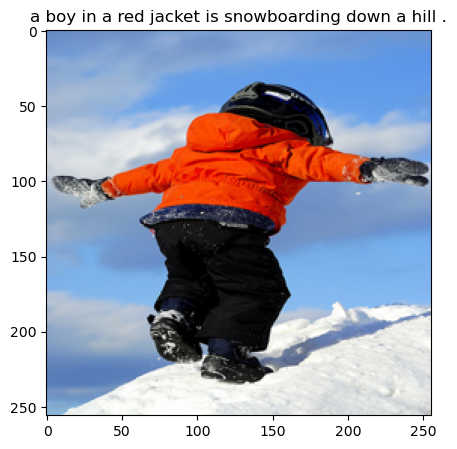

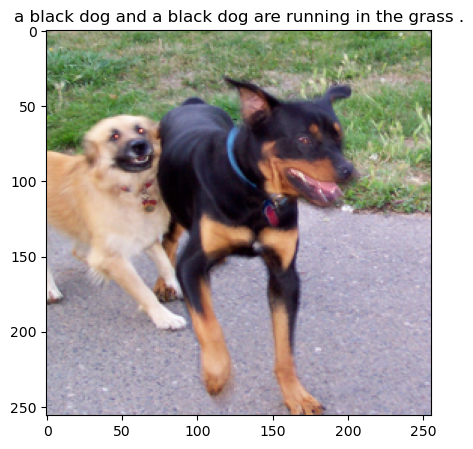

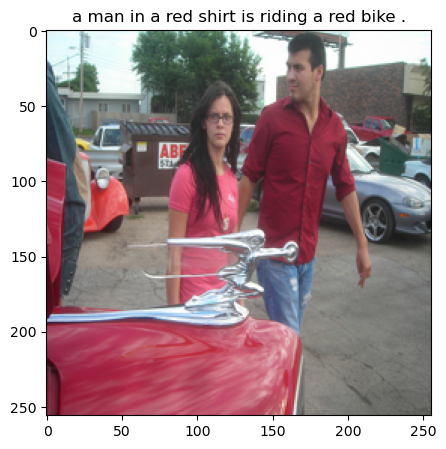

In [27]:
for i in range(10):
    img, cap, flr = next(iter(test_loader))
    fig, axes = plt.subplots(1, 1, figsize=(5, 5))
    axes.imshow((img[0]))
    axes.set_title(generate(transofrm(img[0])))